In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
## paths
# folder_path_M = '/Users/maximehenon/Documents/GitHub/MAR25_BDS_Compagnon_Immo/'
# folder_path_Y = 'C:/Users/charl/OneDrive/Documents/Yasmine/DATASCIENTEST/FEV25-BDS-COMPAGNON'
folder_path_C = '../data/processed/Sales'

# Load the dataset
# output_file = os.path.join(folder_path_M, 'df_sales_clean.csv')
# output_file = os.path.join(folder_path_Y, 'df_sales_clean.csv')
output_file = os.path.join(folder_path_C, 'df_annonces_gps_iris_ventes_83.csv')

chunksize = 100000  # Number of rows per chunk
chunks = pd.read_csv(output_file, sep=';', chunksize=chunksize, index_col='date',  parse_dates=['date'], on_bad_lines='skip', low_memory=False)
# Process chunks
df_sales = pd.concat(chunk for chunk in chunks).sort_values(by='date')
df_sales = df_sales.drop_duplicates()

# Transformation logarithmique
def log_transform(data, column,):
    data[column] = np.log1p(data[column])
    return data

# Filter df_sales for multiple INSEE_COM values
insee_com_values = [83119]
df_sales = df_sales[df_sales['INSEE_COM'].isin(insee_com_values)]

X_train, X_test = train_test_split(df_sales,test_size=0.2, random_state=42)

X_train = log_transform(X_train,'prix_m2_vente')
X_test = log_transform(X_test,'prix_m2_vente')

In [3]:
X_train = X_train[['prix_m2_vente']]
X_test = X_test[['prix_m2_vente']]

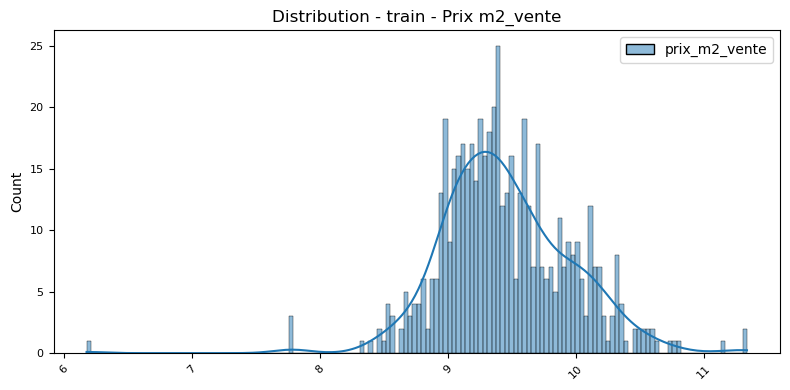

In [4]:
plt.figure(figsize=(8, 4))
sns.histplot(data=X_train, bins=150, kde=True)
plt.title('Distribution - train - Prix m2_vente')
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [5]:
train_periodique_q12 = X_train.groupby('date').agg({'prix_m2_vente':'mean'})
train_periodique_q12.index

train_periodique_q12 = train_periodique_q12.loc['2020':'2023']

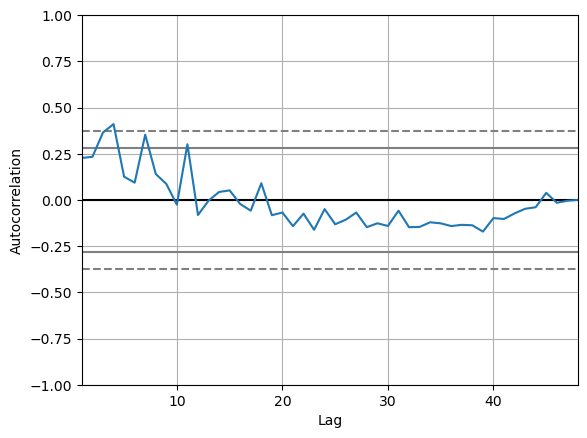

In [6]:
train_periodique_q12_log = np.log(train_periodique_q12)
pd.plotting.autocorrelation_plot(train_periodique_q12_log);

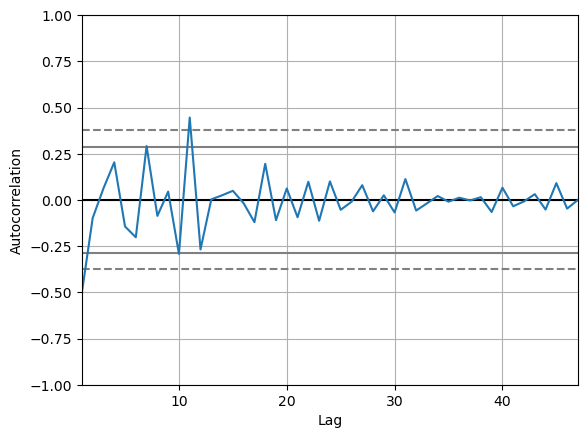

In [7]:
train_periodique_q12_log_diff = train_periodique_q12_log.diff().dropna() #différenciation et supp. des nan 

pd.plotting.autocorrelation_plot(train_periodique_q12_log_diff);

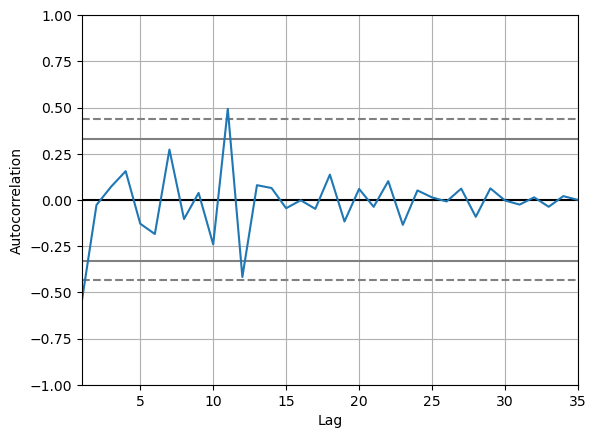

In [8]:
train_periodique_q12_log_2 = train_periodique_q12_log_diff.diff(periods = 12).dropna() 

pd.plotting.autocorrelation_plot(train_periodique_q12_log_2); 

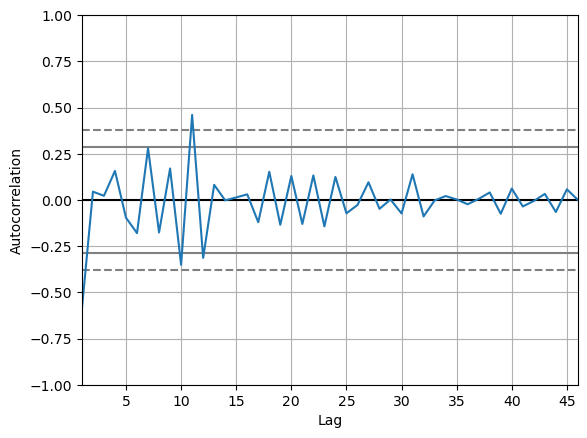

In [9]:
train_periodique_q12_log_2 = train_periodique_q12_log_diff.diff().dropna() # Différenciation d'ordre 2 et supp. des nan

pd.plotting.autocorrelation_plot(train_periodique_q12_log_2); # Autocorrélogramme de la série

In [10]:
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss

_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(train_periodique_q12_log_2)
print(p_value)

0.03998030816923978


In [11]:
# Fonction pour effectuer le test ADF
def test_stationarity(timeseries, window=12):
    # Calculer la moyenne mobile et l'écart type mobile
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Tracer la série temporelle, la moyenne mobile et l'écart type mobile
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Série originale')
    plt.plot(rolmean, color='red', label='Moyenne mobile')
    plt.plot(rolstd, color='black', label='Écart type mobile')
    plt.legend(loc='best')
    plt.title('Moyenne mobile et écart type mobile')
    plt.grid(True)
    plt.show()

    # Effectuer le test ADF
    result = adfuller(timeseries.dropna())
    print('Résultats du test ADF:')
    print('Statistique ADF:', result[0])
    print('p-value:', result[1])
    print('Valeurs critiques:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

    # Interprétation des résultats
    if result[1] < 0.05:
        print("La série est stationnaire (p-value < 0.05)")
    else:
        print("La série n'est pas stationnaire (p-value >= 0.05)")

Test ADF sur les données originales:


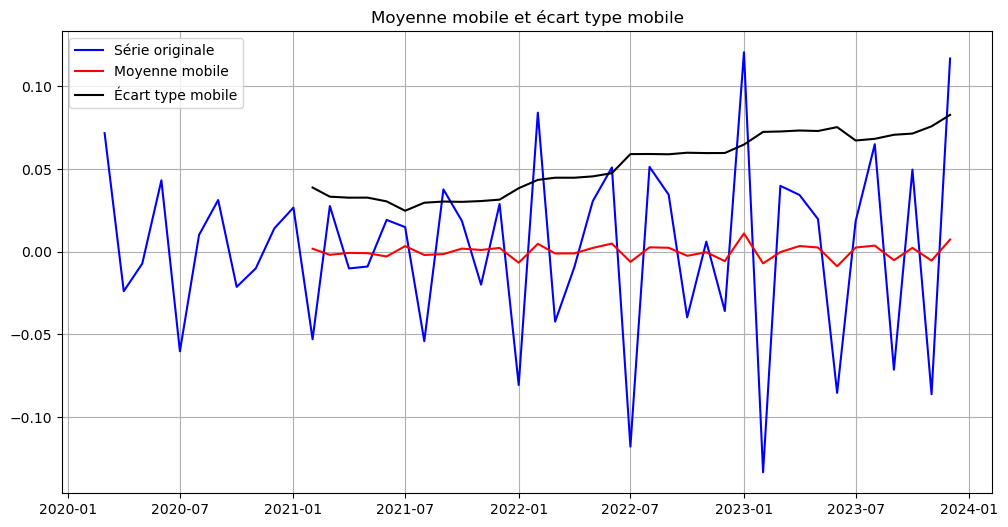

Résultats du test ADF:
Statistique ADF: -2.9486100825837394
p-value: 0.03998030816923978
Valeurs critiques:
	1%: -3.626651907578875
	5%: -2.9459512825788754
	10%: -2.6116707716049383
La série est stationnaire (p-value < 0.05)


In [12]:
# Effectuer le test ADF sur les données originales
print("Test ADF sur les données originales:")
test_stationarity(train_periodique_q12_log_2)

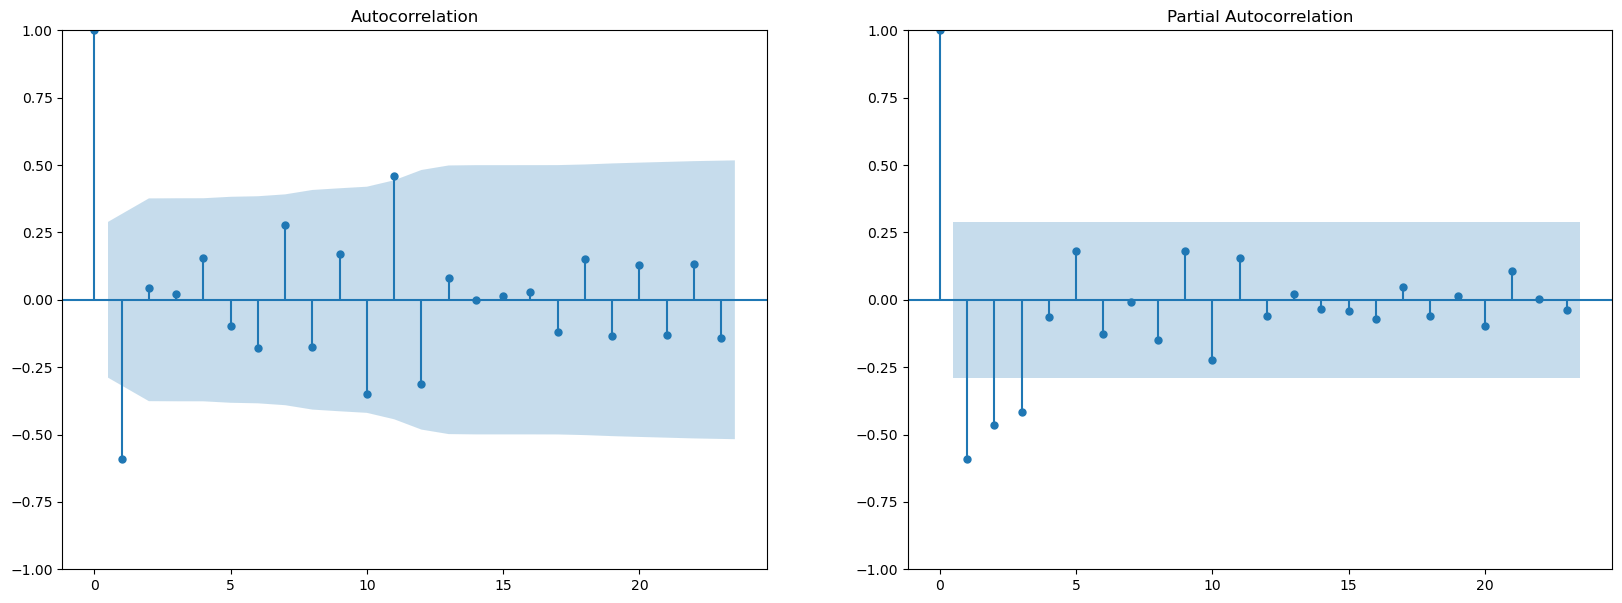

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calculate the maximum allowable lags
max_lags = len(train_periodique_q12_log_2) // 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Use the maximum allowable lags for ACF and PACF
plot_acf(train_periodique_q12_log_2, lags=max_lags, ax=ax1)
plot_pacf(train_periodique_q12_log_2, lags=max_lags, ax=ax2)
plt.show()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_periodique_q12_log, order=(2, 2, 3), seasonal_order=(0, 1, 0, 12))
results = model.fit()

print(results.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                       prix_m2_vente   No. Observations:                   48
Model:             SARIMAX(2, 2, 3)x(0, 1, [], 12)   Log Likelihood                  64.512
Date:                             Mon, 12 May 2025   AIC                           -117.024
Time:                                     10:21:39   BIC                           -107.865
Sample:                                 01-01-2020   HQIC                          -113.900
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0187      0.215      0.087      0.931      -0.403       0.441
ar.L2         -0.4432      

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


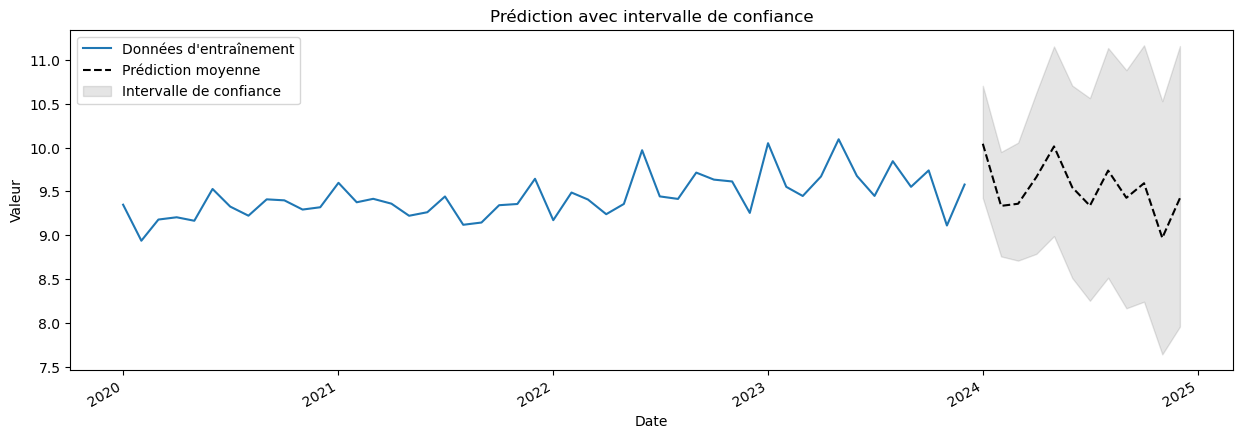

In [15]:
#Prédiction avec intervalle de confiance
prediction = results.get_forecast(steps = 12).summary_frame() 

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(train_periodique_q12, label='Données d\'entraînement')
#Passage à l'exponentielle
prediction = np.exp(prediction) 
#Visualisation de la moyenne
prediction['mean'].plot(ax = ax, style = 'k--', label='Prédiction moyenne') 
#Visualisation de l'intervalle de confiance
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1,label='Intervalle de confiance')

plt.legend()
plt.title('Prédiction avec intervalle de confiance')
plt.xlabel('Date')
plt.ylabel('Valeur');

In [16]:
train_periodique_q12_real = X_test.groupby('date').agg(prix_m2_vente=('prix_m2_vente','mean'))
train_periodique_q12_real = train_periodique_q12_real.loc['2023':'2025']

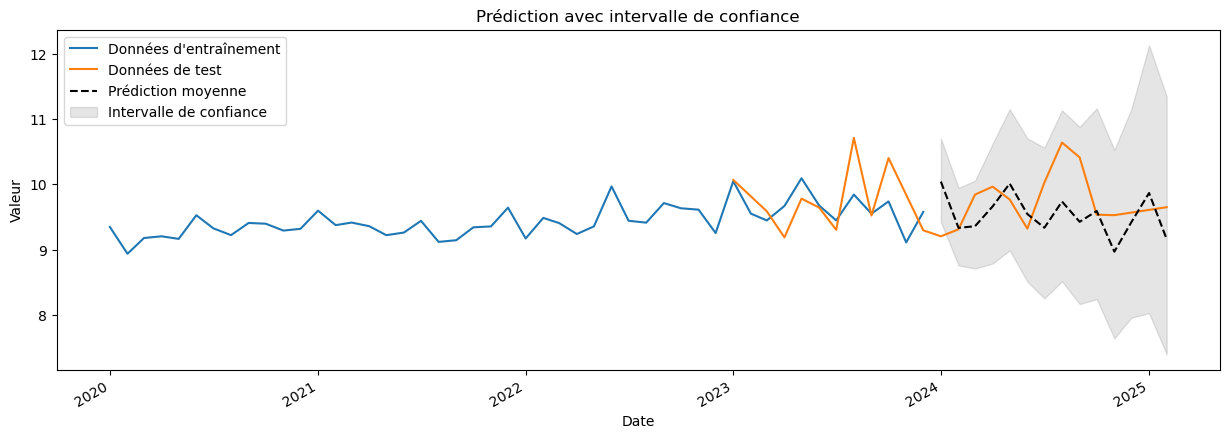

In [17]:
#Prédiction avec intervalle de confiance
prediction = results.get_forecast(steps = 14).summary_frame()  

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(train_periodique_q12, label='Données d\'entraînement')
plt.plot(train_periodique_q12_real, label='Données de test')

#Passage à l'exponentielle
prediction = np.exp(prediction) 

#Visualisation de la moyenne
prediction['mean'].plot(ax = ax, style = 'k--',label='Prédiction moyenne') 

#Visualisation de l'intervalle de confiance
ax.fill_between(
    prediction.index, 
    prediction['mean_ci_lower'], 
    prediction['mean_ci_upper'], 
    color='k', 
    alpha=0.1, 
    label='Intervalle de confiance'); 

plt.legend()
plt.title('Prédiction avec intervalle de confiance')
plt.xlabel('Date')
plt.ylabel('Valeur');

In [18]:
erreur_relative_pct = 100 * np.abs((train_periodique_q12_real.prix_m2_vente - prediction['mean']) / train_periodique_q12_real.prix_m2_vente)
erreur_relative_pct.mean()

4.892973023591721